### Training Notebook : Image Classification Task for ML Internship 2023

In [2]:
! pip install tensorflow
! pip install matplotlib

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.layers import Dropout
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom

#### 1. Loading of the dataset downloaded on the local disk

In [3]:
# CHANGE THE PATH OF DATA_DIR
data_dir = "C:/Users/camil/Desktop/Image_Classification/EuroSAT/2750"
batch_size = 32
img_height = 64
img_width = 64

##### We use 80% of the dataset for training and 20% for validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [6]:
class_names = train_ds.class_names
print("Number of classes :",len(class_names))
print("class_names :",class_names)

Number of classes : 10
class_names : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


##### This shape confirm that the images that are to be fed to the network are by batch of 32 at the right dimension (64x64) in RGB (so 3 channels).

#### 2. Setup dataset for performances

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 3. Data augmentation in order to prevent overfitting
##### Data augmentation produces more images from the original dataset with some modifications like a random zoom, flip or rotation. With more images the network will have more training example to work with and therefore will perform better on new data.

In [9]:
data_augmentation = Sequential()

data_augmentation.add(RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
data_augmentation.add(RandomZoom(0.1))
data_augmentation.add(RandomRotation(0.1))

#### 4. Creation of the model for classification

In [10]:
num_classes = len(class_names)

In [11]:
model = Sequential() # initialisation of the CNN

model.add(data_augmentation) # we use the data augmentation layers within the model which will be saved

model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3))) # Rescaling layer for the RGB channels

# layer 1 - Convolution
model.add(Conv2D(16, 3, padding='same', activation='relu')) # relu effective in promoting sparsity and reducing training time

# 1st bloc : layer 2 - Convolution and layer 3 - Pooling
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) # reduce the spatial dimensions of the feature maps while retaining the most important features. This can help to reduce the computational cost of the model and prevent overfitting.

# layer 4 - Convolution
model.add(Conv2D(32, 3, padding='same', activation='relu'))

# 2nd bloc 
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd bloc
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# layer 9 - Flattening
model.add(Flatten())

# layer 10 - Full connection 
model.add(Dense(64, activation='relu'))

# layer 11 - Dropout of 20% of the output of the layer 10 used in order to reduce overfitting
model.add(Dropout(0.2)) 

model.add(Dense(num_classes))

#### 5. Model compilation

In [12]:
model.compile(
    optimizer="adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # because we have more than 2 classes and logits true because no softmax activation
    metrics=['accuracy']
)

In [13]:
model.summary() # display the architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                      

#### 6. Model training

In [31]:
epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/40
675/675 [==============================] - 104s 140ms/step - loss: 1.5139 - accuracy: 0.4186 - val_loss: 0.9775 - val_accuracy: 0.6530
Epoch 2/40
675/675 [==============================] - 94s 139ms/step - loss: 0.9477 - accuracy: 0.6590 - val_loss: 0.7442 - val_accuracy: 0.7191
Epoch 3/40
675/675 [==============================] - 94s 139ms/step - loss: 0.7599 - accuracy: 0.7259 - val_loss: 0.6263 - val_accuracy: 0.7681
Epoch 4/40
675/675 [==============================] - 93s 138ms/step - loss: 0.6615 - accuracy: 0.7666 - val_loss: 0.7344 - val_accuracy: 0.7487
Epoch 5/40
675/675 [==============================] - 93s 138ms/step - loss: 0.6062 - accuracy: 0.7875 - val_loss: 0.5906 - val_accuracy: 0.7954
Epoch 6/40
675/675 [==============================] - 94s 139ms/step - loss: 0.5531 - accuracy: 0.8040 - val_loss: 0.5212 - val_accuracy: 0.8267
Epoch 7/40
675/675 [==============================] - 91s 135ms/step - loss: 0.5078 - accuracy: 0.8216 - val_loss: 0.4373 - val_a

#### 7. Model performance evaluation

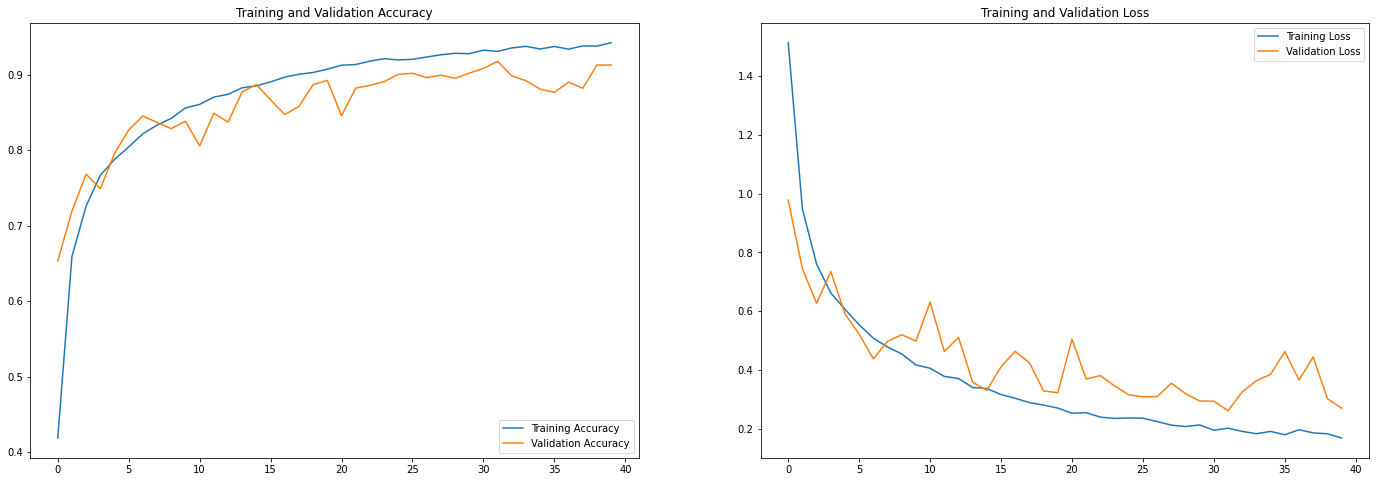

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 8. Model saving

In [36]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
